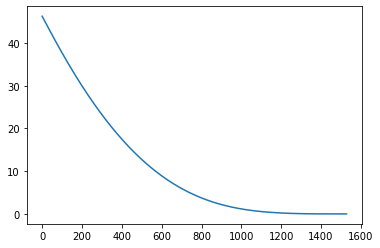

In [1]:
import numpy as np

class adadelta:
    def __init__(self,fun,grad=None,
                 grad_eps=1e-8,
                 args=(),
                 kwargs={}):
        self.fun = fun
        self.grad = grad
        self.args = args
        self.kwargs = kwargs
        self.res = {"f":[],
                    "x":[],
                    "iter":0,
                    "success":True}
        if grad is None: 
            self.grad_eps = grad_eps
            self.grad = self.set_grad
    def set_grad(self,x,*args,**kwargs):
        _f = lambda x: self.fun(x,*self.args,**self.kwargs)
        eps = self.grad_eps
        N = len(x)
        grad = []
        dx = np.zeros(N)
        for i in range(N):
            dx[i] = eps
            grad.append((_f(x+dx)-_f(x-dx))/(2*eps))
            dx[i] = 0
        return np.array(grad)
    def E(self,Eprev,gx,rho):
        return rho*Eprev + (1 - rho)*gx**2
    def RMS(self,E,gx,eps):
        return np.sqrt(E + eps)
    def minimize(self,x0,
                 rho=0.95,
                 eps=1e-6,
                 rtol=1e-05, 
                 atol=1e-08,
                 maxitr=10000):
        _f = lambda x: self.fun(x,*self.args,**self.kwargs)
        _df = lambda x: self.grad(x,*self.args,**self.kwargs)
        Eg = Ex = 0
        x = np.array(x0)
        dx = 0
        cnt = 0
        res = []
        while True:
            df = _df(x)
            Eg = self.E(Eg,df,rho)
            dx = -(self.RMS(Ex,dx,eps)/self.RMS(Eg,df,eps))*df
            Ex = self.E(Ex,dx,rho)
            if np.isclose(_f(x),_f(x+dx),rtol,atol):
                break
            res.append([*x,_f(x)])
            cnt += 1
            if cnt > maxitr:
                print("minimization failed to converge")
                self.res["success"] = False
                break
            x = x + dx
        res = np.array(res)
        self.res.update({"f":res[:,-1],
                         "x":res[:,:-1],
                         "iter":cnt})
        return x

if __name__ == "__main__":
    import matplotlib.pyplot as plt
    def f(x):
        return (x[0]-3.5)**2 + (x[1]-2)**2
    def df(x):
        return np.array([2*(x[0]-3.5),2*(x[1]-2)])

    fmin = adadelta(f)
    x = fmin.minimize([-2,-2])

    fs = fmin.res["f"]
    plt.plot(fs)
    plt.show()